Energy: 3.2810835727404717
Energy: 3.3064413167566644
Energy: 3.3009721702552306
Energy: 3.2857590179405323
Energy: 3.286117612256374
Energy: 3.299325523394838
Energy: 3.3080372010107864
Energy: 3.344138109302739
Energy: 3.3329350963611017
Energy: 3.3124368516883638
Energy: 3.316924010822356
Energy: 3.3178318441247043
Energy: 3.305851748459457
Energy: 3.317231654393458
Energy: 3.3035661335250626
Energy: 3.3169783072120533
Energy: 3.3111812136417
Energy: 3.3236929670571733
Energy: 3.322137270716776
Energy: 3.3582646104995555
Energy: 3.311981442104823
Energy: 3.289179249515751
Energy: 3.2784014284608305
Energy: 3.2986217736347907
Energy: 3.2714129435669648
Energy: 3.2756901123376756
Energy: 3.2986060797275774
Energy: 3.273086338259273
Energy: 3.2656836400287204
Energy: 3.274934213496771
Energy: 3.2742767132350847
Energy: 3.2752846118048566
Energy: 3.290270969814218
Energy: 3.2776726333346824
Energy: 3.297833785602208
Energy: 3.337449443435743
Energy: 3.277310764926129
Energy: 3.275934999

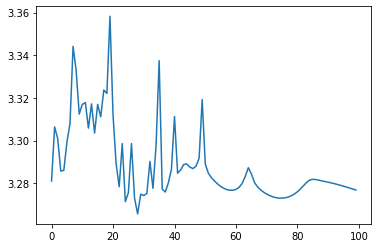

In [17]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added restricted boltzmann machine method for dealing with the wavefunction
# RBM code based heavily off of:
# https://github.com/CompPhysics/ComputationalPhysics2/tree/gh-pages/doc/Programs/BoltzmannMachines/MLcpp/src/CppCode/ob
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,a,b,w):
    sigma=1.0
    sig2 = sigma**2
    Psi1 = 0.0
    Psi2 = 1.0
    Q = Qfac(r,b,w)
    
    
    for iq in range(NumberParticles):
        for ix in range(Dimension):
            Psi1 += (r[iq,ix]-a[iq,ix])**2
            
    for ih in range(NumberHidden):
        Psi2 *= (1.0 + np.exp(Q[ih]))
        
    Psi1 = np.exp(-Psi1/(2*sig2))

    return Psi1*Psi2

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,a,b,w):
    sigma=1.0
    sig2 = sigma**2
    locenergy = 0.0
    
    Q = Qfac(r,b,w)

    for iq in range(NumberParticles):
        for ix in range(Dimension):
            sum1 = 0.0
            sum2 = 0.0
            for ih in range(NumberHidden):
                sum1 += w[iq,ix,ih]/(1+np.exp(-Q[ih]))
                sum2 += w[iq,ix,ih]**2 * np.exp(Q[ih]) / (1.0 + np.exp(Q[ih]))**2
    
            dlnpsi1 = -(r[iq,ix] - a[iq,ix]) /sig2 + sum1/sig2
            dlnpsi2 = -1/sig2 + sum2/sig2**2
            locenergy += 0.5*(-dlnpsi1*dlnpsi1 - dlnpsi2 + r[iq,ix]**2)
            
    if(interaction==True):
        for iq1 in range(NumberParticles):
            for iq2 in range(iq1):
                distance = 0.0
                for ix in range(Dimension):
                    distance += (r[iq1,ix] - r[iq2,ix])**2
                    
                locenergy += 1/sqrt(distance)
                
    return locenergy

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,a,b,w):
    
    sigma=1.0
    sig2 = sigma**2
    
    Q = Qfac(r,b,w)
    
    WfDer = np.empty((3,),dtype=object)
    WfDer = [np.copy(a),np.copy(b),np.copy(w)]
    
    WfDer[0] = (r-a)/sig2
    WfDer[1] = 1 / (1 + np.exp(-Q))
    
    for ih in range(NumberHidden):
        WfDer[2][:,:,ih] = w[:,:,ih] / (sig2*(1+np.exp(-Q[ih])))
            
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,a,b,w):

    sigma=1.0
    sig2 = sigma**2
    
    qforce = np.zeros((NumberParticles,Dimension), np.double)
    sum1 = np.zeros((NumberParticles,Dimension), np.double)
    
    Q = Qfac(r,b,w)
    
    for ih in range(NumberHidden):
        sum1 += w[:,:,ih]/(1+np.exp(-Q[ih]))
    
    qforce = 2*(-(r-a)/sig2 + sum1/sig2)
    
    return qforce
    
def Qfac(r,b,w):
    Q = np.zeros((NumberHidden), np.double)
    temp = np.zeros((NumberHidden), np.double)
    
    for ih in range(NumberHidden):
        temp[ih] = (r*w[:,:,ih]).sum()
        
    Q = b + temp
    
    return Q
    
# Computing the derivative of the energy and the energy 
def EnergyMinimization(a,b,w):

    NumberMCcycles= 10000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed(3456347)
    energy = 0.0
    DeltaE = 0.0

    EnergyDer = np.empty((3,),dtype=object)
    DeltaPsi = np.empty((3,),dtype=object)
    DerivativePsiE = np.empty((3,),dtype=object)
    EnergyDer = [np.copy(a),np.copy(b),np.copy(w)]
    DeltaPsi = [np.copy(a),np.copy(b),np.copy(w)]
    DerivativePsiE = [np.copy(a),np.copy(b),np.copy(w)]
    for i in range(3): EnergyDer[i].fill(0.0)
    for i in range(3): DeltaPsi[i].fill(0.0)
    for i in range(3): DerivativePsiE[i].fill(0.0)

    local_Energy_vector = np.zeros(NumberMCcycles)
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            #PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
            # read from files
            PositionOld[i,j] = np.loadtxt("./tests/Data/wfpos.txt").reshape(NumberParticles,Dimension)[i,j]
    wfold = WaveFunction(PositionOld,a,b,w)
    QuantumForceOld = QuantumForce(PositionOld,a,b,w)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,a,b,w)
            QuantumForceNew = QuantumForce(PositionNew,a,b,w)
            
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
                                      (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        #print("wf new:        ", wfnew)
        #print("force on 1 new:", QuantumForceNew[0,:])
        #print("pos of 1 new:  ", PositionNew[0,:])
        #print("force on 2 new:", QuantumForceNew[1,:])
        #print("pos of 2 new:  ", PositionNew[1,:])
        DeltaE = LocalEnergy(PositionOld,a,b,w)
        # save local energy to a vector to print

        DerPsi = DerivativeWFansatz(PositionOld,a,b,w)
        
        DeltaPsi[0] += DerPsi[0]
        DeltaPsi[1] += DerPsi[1]
        DeltaPsi[2] += DerPsi[2]
        
        energy += DeltaE

        DerivativePsiE[0] += DerPsi[0]*DeltaE
        DerivativePsiE[1] += DerPsi[1]*DeltaE
        DerivativePsiE[2] += DerPsi[2]*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE[0] /= NumberMCcycles
    DerivativePsiE[1] /= NumberMCcycles
    DerivativePsiE[2] /= NumberMCcycles
    DeltaPsi[0] /= NumberMCcycles
    DeltaPsi[1] /= NumberMCcycles
    DeltaPsi[2] /= NumberMCcycles
    EnergyDer[0]  = 2*(DerivativePsiE[0]-DeltaPsi[0]*energy)
    EnergyDer[1]  = 2*(DerivativePsiE[1]-DeltaPsi[1]*energy)
    EnergyDer[2]  = 2*(DerivativePsiE[2]-DeltaPsi[2]*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
NumberHidden = 10

interaction=True

# guess for parameters
a=np.random.normal(loc=0.0, scale=0.001, size=(NumberParticles,Dimension))
#a=np.loadtxt("./tests/Data/a.txt").reshape(NumberParticles,Dimension)

b=np.random.normal(loc=0.0, scale=0.001, size=(NumberHidden))
#b=np.loadtxt("./tests/Data/b.txt").reshape(NumberHidden)
w=np.random.normal(loc=0.0, scale=0.1/np.sqrt(NumberHidden), size=(NumberParticles,Dimension,NumberHidden))
#w=np.loadtxt("./tests/Data/w.txt").reshape(NumberParticles,Dimension,NumberHidden)
# Set up iteration using stochastic gradient method
Energy = 0
EDerivative = np.empty((3,),dtype=object)
EDerivative = [np.copy(a),np.copy(b),np.copy(w)]
# Learning rate eta, max iterations, need to change to adaptive learning rate
eta = 0.1
MaxIterations = 100
iter = 0
np.seterr(invalid='raise')
Energies = np.zeros(MaxIterations)
EnergyDerivatives1 = np.zeros(MaxIterations)
EnergyDerivatives2 = np.zeros(MaxIterations)

velocity_a = np.zeros((NumberParticles,Dimension))
velocity_b = np.zeros((NumberHidden))
velocity_w = np.zeros((NumberParticles,Dimension,NumberHidden))

while iter < MaxIterations:
    Energy, EDerivative = EnergyMinimization(a,b,w)
    
    agradient = EDerivative[0]
    bgradient = EDerivative[1]
    wgradient = EDerivative[2]

    #add exponential decay to learning rate

    #add momentum for faster convergence


    #velocity_a = 0.9*velocity_a + eta*agradient
    #velocity_b = 0.9*velocity_b + eta*bgradient
    #velocity_w = 0.9*velocity_w + eta*wgradient

    #a -= velocity_a
    #b -= velocity_b
    #w -= velocity_w

    a -= eta*agradient
    b -= eta*bgradient
    w -= eta*wgradient
    
    Energies[iter] = Energy
    print("Energy:",Energy)
    #EnergyDerivatives1[iter] = EDerivative[0] 
    #EnergyDerivatives2[iter] = EDerivative[1]
    #EnergyDerivatives3[iter] = EDerivative[2] 
    iter += 1

# plot energies
import matplotlib.pyplot as plt
plt.plot(Energies)
plt.show()



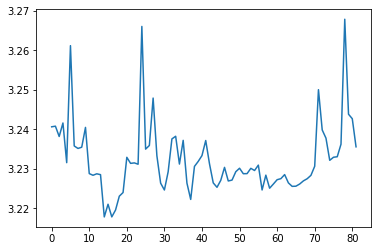

In [11]:
import matplotlib.pyplot as plt
plt.plot(Energies[Energies != 0])
plt.show()